In [6]:
%pylab inline
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import leastsq
def yvals(x):
    return np.sin(x)+np.sin(2*x)+np.sin(3*x)

dx = .1
X = np.arange(0,2*np.pi,dx)
Y = yvals(X)

unknown_shift = np.random.random() * dx
Y_shifted = yvals(X + unknown_shift)

def err_func(p):
    return interp1d(X,Y)(X[1:-1]+p[0]) - Y_shifted[1:-1]

p0 = [0,] # Inital guess of no shift
found_shift = leastsq(err_func,p0)[0][0]

Populating the interactive namespace from numpy and matplotlib


In [3]:
found_shift = leastsq(err_func,p0)[0][0]

print(f"Unknown shift:{unknown_shift} ")
print(f"Found shift:{found_shift} ")


Unknown shift:0.037400451311176044 
Found shift:0.03735497570641239 


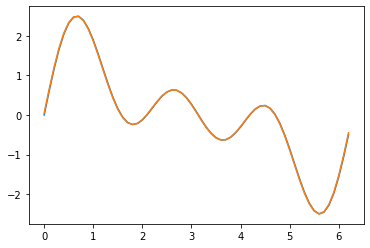

In [7]:
plt.plot(X,Y)
plt.plot(X,Y_shifted)

In [39]:
interp1d(f_time,f_vals)(f_time[1:-1])

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 5.750e-02, 1.295e-01, 2.125e-01, 3.015e-01, 3.975e-01,
       5.050e-01, 6.185e-01, 7.275e-01, 8.190e-01, 8.870e-01, 9.350e-01,
       9.805e-01, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 8.770e-01, 7.160e-01, 5.675e-01,
       4.395e-01, 3.310e-01, 2.415e-01, 1.655e-01, 1.000e-01, 4.800e-02,
       1.000e-03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 3.700e-02, 9.250e-02, 1.615e-01, 2.455e-01, 3.320e-01,
       4.115e-01, 4.905e-01, 5.740e-01, 6.525e-01, 

In [76]:
import yaml
def load_yaml(fname):
    with open(fname, 'r') as file:
        data = yaml.safe_load(file)
    return data

def compute_normalized_force_response(device_force_values, MVC, forceRangeMin=0.05, forceRangeMax=0.30, clamp=None):
    """
    Convert from sensor values to heigt values that were used in the display for direct comparison to the target sequence. Works fine for any array.
    ((deviceForceValue / MVC) - forceRangeMin)/(forceRangeMax-forceRangeMin)

    MVC:            maximumum voluntary contraction of this individual (in original device units)
    clamp:          list of min/max values to clamp any values that are above or below to, default = None (no clamping)
    """

    norm_resp = ((device_force_values / MVC) - forceRangeMin)/(forceRangeMax-forceRangeMin)
    if clamp is not None:
        norm_resp[norm_resp<clamp[0]] = clamp[0]
        norm_resp[norm_resp>clamp[1]] = clamp[1]
    return norm_resp

In [77]:
data = load_yaml('./testing/TEST_out-file.yml')
blocks = data['blocks']
# input data 1st block 1st trial (left): blocks[0]['trials'][0]['leftReference']
#       times,values
#block start time @ startTimestamp, end @ endTimestamp

MVC = data['maximumLeftVoluntaryContraction']
t_time = np.array(blocks[0]['trials'][0]['leftReference']['times'])
t_vals = np.array(blocks[0]['trials'][0]['leftReference']['values'])

#all times from the device over the course of the experiment
resp = data['devices'][0]
all_f_time = np.array(resp['times'])
all_f_vals = compute_normalized_force_response(np.array(resp['values']),MVC)

#loop this to identify the start and end times of the trials
start = t_time[0]
end = t_time[-1]

f_trial_mask = (all_f_time-start >= 0) & (all_f_time-end<=0)
f_time = all_f_time[f_trial_mask]
f_vals = all_f_vals[f_trial_mask]

t_vals_interp = np.interp(f_time,t_time,t_vals) #linear (piece-wise) interpolation of presented target bar positions into the actual response, now we can subtract directly

#but first we should do the crosscorr
trial_rmse = np.sqrt(np.mean((t_vals_interp-f_vals)**2)) #root mean squared error #TOOD: have someone confirm algo
trial_sse = ((t_vals_interp-f_vals)**2).sum()


In [56]:
plt.plot(interp1d(f_time,t_vals_interp,kind='cubic')(f_time[1:-1]+40) - f_vals[1:-1])

ValueError: A value in x_new is above the interpolation range.

In [57]:
def err_func(p):
    print(p)
    return interp1d(f_time,t_vals_interp,fill_value="extrapolate")(f_time[1:-1]+p[0]) - f_vals[1:-1]

p0 = [0,] # Inital guess of no shift
found_shift = leastsq(err_func,p0)[0][0]

[0]
[0.]
[0.]
[1.49011612e-08]
[43.85663121]
[43.85663186]
[75.77818409]
[75.77818522]
[106.51907261]
[106.5190742]
[136.89578893]
[136.89579097]
[156.66973844]
[156.66974078]
[176.33277135]
[176.33277398]
[192.10592087]
[192.10592373]
[205.79148946]
[205.79149253]
[215.61669761]
[215.61670082]
[225.43243101]
[225.43243437]
[235.20201161]
[235.20201511]
[241.34768707]
[241.34769066]
[244.8743289]
[244.87433255]
[244.87472806]


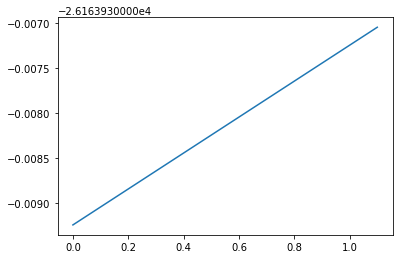

In [69]:
x_new = np.linspace(0,1.1,1000)
intfunc = interp1d(f_time,t_vals_interp,fill_value="extrapolate")

# plt.plot(f_time,t_vals_interp)
plt.plot(x_new,intfunc(x_new))

In [74]:
f_time.max()

13106296.01

In [78]:
crosscorr = np.correlate(f_vals,t_vals_interp,mode='full')
max_idx = np.where(crosscorr==np.max(crosscorr))[0]
if max_idx.shape[0] > 1:
    print("Oh no, you have more than one location with max lag!")
    return 9999


array([149])

array(0)

(array([403]),)

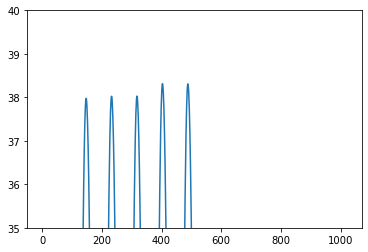

In [34]:
plt.plot(crosscorr),plt.ylim([35,40])
np.where(crosscorr==np.max(crosscorr))